# Condis 

In [56]:
import requests
import numpy as np
import pandas as pd
from functools import reduce
from datetime import datetime,timedelta
import matplotlib.pyplot as plt
%matplotlib inline

In [48]:
# Make GET request
response = requests.get('https://api.weather.gov/gridpoints/PHI/58,91')

In [49]:
# Convert response to python dict
j=response.json()

In [50]:
# Get all properties and then extract the ones I will use
properties=j['properties']

In [51]:
temp_dicts=properties['temperature']
hum_dicts=properties['relativeHumidity']
precip_dicts=properties['probabilityOfPrecipitation']
# May want to consider snow level as well since this may be relevant for certain areas

In [58]:
def init_temp_df():
    temp_lists=temp_dicts['values']
    df_temp=pd.DataFrame(temp_lists)
    df_temp['temp_f']=df_temp['value']*9/5.+32
    df_temp['timestamp']=pd.to_datetime(df_temp['validTime'].map(lambda x: str(x).split('+')[0]))
    # set to local time from UTC (default)
    df_temp['timestamp']-=timedelta(hours=4)
    df_temp['msr_duration']=df_temp['validTime'].map(lambda x: int(str(x).split('PT')[-1].split('H')[0]))
    df_temp.drop(['validTime','value'],axis=1,inplace=True)
    df_temp = df_temp[['timestamp','msr_duration','temp_f']]
    return df_temp

def init_hum_df():
    hum_lists=hum_dicts['values']
    df_hum=pd.DataFrame(hum_lists)
    df_hum['relativeHumidity'] = df_hum['value']
    df_hum['timestamp']=pd.to_datetime(df_hum['validTime'].map(lambda x: str(x).split('+')[0]))
    df_hum['timestamp']-=timedelta(hours=4)
    df_hum['msr_duration']=df_hum['validTime'].map(lambda x: int(str(x).split('PT')[-1].split('H')[0]))
    df_hum.drop(['validTime','value'],axis=1,inplace=True)
    df_hum = df_hum[['timestamp','msr_duration','relativeHumidity']]
    return df_hum

def init_precip_df():
    precip_lists=precip_dicts['values']
    df_precip=pd.DataFrame(precip_lists)
    df_precip['probabilityOfPrecipitation'] = df_precip['value']
    df_precip['timestamp']=pd.to_datetime(df_precip['validTime'].map(lambda x: str(x).split('+')[0]))
    df_precip['timestamp']-=timedelta(hours=4)
    df_precip['msr_duration']=df_precip['validTime'].map(lambda x: int(str(x).split('PT')[-1].split('H')[0]))
    df_precip.drop(['validTime','value'],axis=1,inplace=True)
    df_precip = df_precip[['timestamp','msr_duration','probabilityOfPrecipitation']]
    return df_precip

def expand_dataframe(df):
    """For any rows where the duration of the measurement
    is over more than one hour, make a new row duplicate row 
    (but with incremented timestamp) for each hour in the duration"""
    dfc = df.copy() # makes a copy so the original is not affected
    mask = dfc['msr_duration'] > 1
    n_rows_multiple_durations = len(dfc[mask]) # variable to store the number of rows where the measurement stands for multiple hours
    print(f"There are originally {n_rows_multiple_durations} multiple rows")
    counter = 0
    while n_rows_multiple_durations > 0:
        # Make a new dataframe that is just the rows with multiples
        new_dfc = dfc.loc[mask].copy()
        # set all of the masked rows in the original dataframe to 1 since we will combine back with this dfc in the end
        dfc['msr_duration'][mask]=1
        # In this new dataframe, increment the timestamp by 1 hour and decrement the msr_duration by 1 hour
        new_dfc['timestamp'] += timedelta(hours=1)
        new_dfc['msr_duration']-=1
        # concatenate this new dfc that we have transformed back with the original, and overwrite the original
        dfc = pd.concat([dfc,new_dfc])
        # calculate the new mask of multiples on this concatenated array
        mask = dfc['msr_duration'] > 1
        n_rows_multiple_durations = len(dfc[mask])
        counter+=1
    # Finally sort by timestamp so the rows fall back in order
    dfc = dfc.sort_values('timestamp')
    # set the index to a proper increasing numerical index without duplicates
    dfc.index = list(range(len(dfc)))
    dfc.drop(['msr_duration'],axis=1,inplace=True)
    return dfc

In [59]:
# initialize all dataframes
df_temp = init_temp_df()
df_hum = init_hum_df()
df_precip = init_precip_df()

In [54]:
print(df_temp['msr_duration'].sum())
print(df_hum['msr_duration'].sum())
print(df_precip['msr_duration'].sum())

182
182
181


In [ ]:
# So it looks like at least sometimes the precipitation prediction has one less timestamp.
# After checking it out it seems like it is always at the end
# So when we merge the last value will be clipped off.

In [60]:
# Expand all dataframes
df_temp_expanded = expand_dataframe(df_temp)
df_hum_expanded = expand_dataframe(df_hum)
df_precip_expanded = expand_dataframe(df_precip)

There are originally 14 multiple rows
There are originally 16 multiple rows
There are originally 24 multiple rows


/Users/athair/.local/lib/python3.7/site-packages/ipykernel_launcher.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [61]:
# Merge all three 
dfs = [df_temp_expanded,df_hum_expanded,df_precip_expanded]
df_final = reduce(lambda left,right: pd.merge(left,right,on='timestamp'), dfs)

# df_final = df_temp_expanded.copy()
# df_final['relativeHumidity'] = df_hum_expanded['relativeHumidity']
# df_final['probabilityOfPrecipitation'] = df_precip_expanded['probabilityOfPrecipitation']
df_final

,timestamp,temp_f,relativeHumidity,probabilityOfPrecipitation
0,2020-06-27 07:00:00,68.0,81,20
1,2020-06-27 08:00:00,71.0,79,41
2,2020-06-27 09:00:00,76.0,69,42
3,2020-06-27 10:00:00,73.0,79,38
4,2020-06-27 11:00:00,76.0,76,48
...,...,...,...,...
176,2020-07-04 15:00:00,86.0,48,23
177,2020-07-04 16:00:00,87.0,46,23
178,2020-07-04 17:00:00,85.0,51,23
179,2020-07-04 18:00:00,84.0,53,23


In [70]:
# Now screen for values in certain ranges in both temp and humidity
hum_min=0
hum_max=85
temp_min=40 # fahrenheit 
temp_max=75 
precip_chance_max = 30
temp_mask = (df_final['temp_f'] > temp_min) & (df_final['temp_f']<temp_max)
hum_mask = (df_final['relativeHumidity'] > hum_min) & (df_final['relativeHumidity'] < hum_max) 
precip_mask = df_final['probabilityOfPrecipitation'] < precip_chance_max
good_condis_mask = (temp_mask) & (hum_mask) & (precip_mask)
df_final['condi']=good_condis_mask

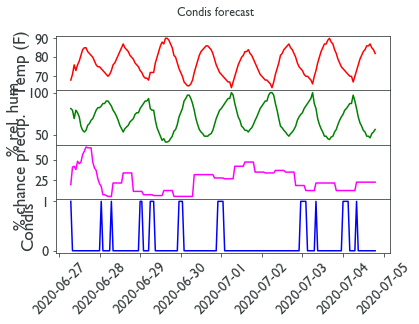

In [71]:
fig, axs = plt.subplots(4, 1, sharex=True)
fig.subplots_adjust(hspace=0)

ax=axs[0]
ax.plot(df_final['timestamp'],df_final['temp_f'],color='r')
ax.set_ylabel("Temp (F)")
# now plot humidity on second axis
ax_hum = axs[1]
ax_hum.plot(df_final['timestamp'],df_final['relativeHumidity'],color='g')
ax_hum.set_ylabel('% rel. hum.')
# now plot the chance of precip
ax_precip = axs[2]
ax_precip.plot(df_final['timestamp'],df_final['probabilityOfPrecipitation'],color='magenta')
ax_precip.set_ylabel('% chance precip.')
# now plot the condis
ax_condi=axs[3]
ax_condi.plot(df_final['timestamp'],df_final['condi'],color='b')
ax_condi.set_ylabel("Condis")
# Rotate tick marks on x-axis
_=plt.setp(ax_condi.get_xticklabels(), rotation=45)
title=fig.suptitle(f"Condis forecast ")

In [72]:
best_times = df_final['timestamp'][good_condis_mask]
best_times

0     2020-06-27 07:00:00
18    2020-06-28 01:00:00
24    2020-06-28 07:00:00
41    2020-06-29 00:00:00
42    2020-06-29 01:00:00
47    2020-06-29 06:00:00
48    2020-06-29 07:00:00
49    2020-06-29 08:00:00
64    2020-06-29 23:00:00
65    2020-06-30 00:00:00
66    2020-06-30 01:00:00
87    2020-06-30 22:00:00
88    2020-06-30 23:00:00
89    2020-07-01 00:00:00
90    2020-07-01 01:00:00
136   2020-07-02 23:00:00
137   2020-07-03 00:00:00
138   2020-07-03 01:00:00
139   2020-07-03 02:00:00
145   2020-07-03 08:00:00
161   2020-07-04 00:00:00
162   2020-07-04 01:00:00
163   2020-07-04 02:00:00
164   2020-07-04 03:00:00
169   2020-07-04 08:00:00
Name: timestamp, dtype: datetime64[ns]

In [83]:
df_good_condis=df_final[['timestamp','temp_f','relativeHumidity','probabilityOfPrecipitation']][good_condis_mask]
df_good_condis

,timestamp,temp_f,relativeHumidity,probabilityOfPrecipitation
0,2020-06-27 07:00:00,68.0,81,20
18,2020-06-28 01:00:00,74.0,84,18
24,2020-06-28 07:00:00,73.0,84,6
41,2020-06-29 00:00:00,73.0,81,12
42,2020-06-29 01:00:00,72.0,84,12
47,2020-06-29 06:00:00,72.0,81,8
48,2020-06-29 07:00:00,72.0,79,8
49,2020-06-29 08:00:00,72.0,79,7
64,2020-06-29 23:00:00,74.0,71,6
65,2020-06-30 00:00:00,72.0,76,6


In [ ]:
# Given this information how to display it?
# One option is table text format, e.g. 
# Wednesday, July 1 from 2:00 PM to 5:00 PM
# Thursday, July 7 from 7:00 AM to 11:00 AM

# Let's see how to do that

In [75]:
def splitme_zip(a,d):
    """ a: numpy array
        d: minimum gap between elements
    """
    m = np.concatenate(([True],a[1:] > a[:-1] + d,[True]))
    idx = np.flatnonzero(m)
    l = a.tolist()
    return [l[i:j] for i,j in zip(idx[:-1],idx[1:])]

In [78]:
a = np.array([1,2,3,5,7,10,13,16,20])
d=1

In [79]:
splitme_zip(a,d)

[[1, 2, 3], [5], [7], [10], [13], [16], [20]]

In [80]:
%%time 
splitme_zip(a,d)

CPU times: user 111 µs, sys: 45 µs, total: 156 µs
Wall time: 140 µs


[[1, 2, 3], [5], [7], [10], [13], [16], [20]]

In [82]:
df_final.index

Int64Index([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,
            ...
            171, 172, 173, 174, 175, 176, 177, 178, 179, 180],
           dtype='int64', length=181)

In [85]:
np.array(df_good_condis.index)

array([  0,  18,  24,  41,  42,  47,  48,  49,  64,  65,  66,  87,  88,
        89,  90, 136, 137, 138, 139, 145, 161, 162, 163, 164, 169])

In [87]:
groups=splitme_zip(np.array(df_good_condis.index),d=1)

In [127]:
time_format = '%-I %p'

In [128]:
for group in groups:
    mask = df_good_condis.index.isin(group)
    group_df = df_good_condis[mask]
#     print(group_df)
    if len(group) > 1:

        first_timestamp = group_df['timestamp'].iloc[0]
        first_date = first_timestamp.date()
        first_time = first_timestamp.time()
        last_timestamp = group_df['timestamp'].iloc[-1]
        last_date = last_timestamp.date()
        last_time = last_timestamp.time()
        
        if first_date == last_date:
            print(f"{first_date}, from {first_time.strftime(time_format)} to {last_time.strftime(time_format)} ")
        else:
            print(f"From {first_time.strftime(time_format)} on {first_date} to {last_time.strftime(time_format)} on {last_date} ")
    else:
        timestamp = group_df['timestamp'].iloc[0]
        date = timestamp.date()
        time = timestamp.time()
        print(f"{date} at {time.strftime(time_format)}")
    print()
#         print(type(first_timestamp))
#     print(group)
#     print(group_df)
#     print()

2020-06-27 at 7 AM

2020-06-28 at 1 AM

2020-06-28 at 7 AM

2020-06-29, from 12 AM to 1 AM 

2020-06-29, from 6 AM to 8 AM 

From 11 PM on 2020-06-29 to 1 AM on 2020-06-30 

From 10 PM on 2020-06-30 to 1 AM on 2020-07-01 

From 11 PM on 2020-07-02 to 2 AM on 2020-07-03 

2020-07-03 at 8 AM

2020-07-04, from 12 AM to 3 AM 

2020-07-04 at 8 AM



In [95]:
df_good_condis.index.isin([169])

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False,  True])